
# Société Générale Electricity Data Science Challenge

We can first start by analyzing the data and its properties before proceeding to pre-processing and finally to training and testing some machine learning algorithms.
Because of the tabular nature of the data, tree methods immediately come to mind as the best algorithms. They are relatively computationally cheap with good performance compared to other algorithms on similar data.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os 
path = "/content/drive/MyDrive/Electricity"

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

X = pd.read_csv(os.path.join(path, "training_inputs.csv"), header=0, sep=";")
X.set_index("ID", inplace=True)
y = pd.read_csv(os.path.join(path, "training_outputs.csv"), header=0, sep=";")
y.set_index("ID", inplace=True)

pd.set_option('display.max_rows', 120)

print(X)
print(y)

       COD_INSEE     COD_IRIS  C1  C2 C3  ...    Q71    Q72    Q73    Q74    Q75
ID                                        ...                                   
0        92025.0  920250102.0  EA  RA  C  ...  false  false    NaN    NaN    NaN
1        17359.0  173590000.0  EA  RA  C  ...  false  false   True  False  False
2        48156.0  481560000.0  EA  RC  B  ...  false  false    NaN    NaN    NaN
3        82125.0  821250000.0  EA  RA  C  ...  false  false    NaN    NaN    NaN
4        64422.0  644220102.0  EA  RA  B  ...  false  false    NaN    NaN    NaN
...          ...          ...  ..  .. ..  ...    ...    ...    ...    ...    ...
85524        NaN          NaN  EA  RA  C  ...   true   true    NaN    NaN    NaN
85525    74158.0  741580000.0  EA  RA  C  ...  false  false  False  False  False
85526    84007.0  840070114.0  EA  RA  B  ...  false  false    NaN    NaN    NaN
85527    83130.0  831300105.0  EA  RA  C  ...  false  false    NaN    NaN    NaN
85528    33281.0  332810301.

## Statistical Analysis
The data is tabular and there are numbers, booleans, strings and dates.

In [5]:
ratio_shallow_rows = (X.shape[0] - X.dropna().shape[0]) / X.shape[0]
print(f"The percentage of rows with missing values is {100*ratio_shallow_rows}%.")

The percentage of rows with missing values is 100.0%.


In [6]:
ratio_shallow_rows = (X.shape[0] - X.dropna().shape[0]) / X.shape[0]
print(f"The percentage of rows with missing values is {100*ratio_shallow_rows}%.\n\n")

percent_missing = X.isnull().sum() * 100 / len(X)
pd.set_option('display.max_rows', 120)
print("Percent missing per column\n", percent_missing)

The percentage of rows with missing values is 100.0%.


Percent missing per column
 COD_INSEE     2.077658
COD_IRIS      2.019198
C1            0.000000
C2            0.000000
C3            0.000000
C4            0.000000
C5            0.000000
C6            0.000000
C7            0.000000
C8            0.000000
C9            0.000000
C10           0.000000
C11           0.000000
C12           0.000000
C13           0.000000
C14           0.000000
C15           0.000000
C16           0.000000
C17           0.000000
C18           0.000000
C19           0.000000
S1           31.405722
S2            0.000000
S3            0.000000
S4            0.000000
S5            0.000000
S6           31.405722
S7           31.405722
S8            0.000000
S9            0.000000
S10           0.000000
S11           0.000000
S12           0.000000
Q1            0.000000
Q2            0.009354
Q3            0.002338
Q4            0.002338
Q5            0.000000
Q6           67.807410
Q7           67.646

In [7]:
ratio_pos_labels = y[y['TARGET'] == 1].shape[0] / y.shape[0]
print(f"Percent of class 1 : {100*ratio_pos_labels:.3f}%.")

Percent of class 1 : 19.360%.


There is also an imbalance of the labels in the dataset will less than one fifth being positive and the rest being negative. While not an extreme imbalance, this cannot be ignored. We can proceed by using well fitting metrics to test performance or by training with balanced training and validation sets.

## Preprocessing
- Numbers:
    Numbers can remain numbers and trees don't require normalization but we can use the StandardScaler anyway. For some columns, they can be categorized because they do not refer to quantites such as contract references. Area codes are interesting in that similar numbers may refer to the same area.
- Booleans
    Changed to 0 and 1
- Strings:
    One Hot encoding
- Dates:
    Should be changed to number of days from a certain time. However, there could be correlations with the seasons that the date is in.

In [8]:
import re
from datetime import date

DROP_INSEE_IRIS = True
DROP_CORRELATED = True
ADD_SEASONALITY = False
ONE_HOT = True
CORR_THRESHOLD = 1.0

def convert_date(s):
    ref_date = date(2011, 1, 1)
    pattern = re.compile("^\d{4}\-(0[1-9]|1[012])\-(0[1-9]|[12][0-9]|3[01])$")
    if isinstance(s, str) and pattern.match(s):
        curr_date = date(int(s[0:4]), int(s[5:7]), int(s[8:10]))
        return (curr_date-ref_date).days
    else:
        return s

def get_season(month):
    dic = {1:'winter',2:'winter',3:'spring',4:'spring',5:'spring',6:'summer',7:'summer',8:'summer',9:'fall',10:'fall',11:'fall', 12:'winter'}
    if month in dic:
        return dic[month]

# Clean the boolean values
X = X.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
X = X.applymap(lambda x: 1 if isinstance(x, str) and x == "true" else x)
X = X.applymap(lambda x: 0 if isinstance(x, str) and x == "false" else x)
X = X.applymap(lambda x: 1 if isinstance(x, bool) and x is True else x)
X = X.applymap(lambda x: 0 if isinstance(x, bool) and x is False else x)


if ADD_SEASONALITY:

    X['S3_month'] = X['S3'].map(lambda x: int(x[5:7]) if not pd.isnull(x) else np.nan)
    X['S3_month_sin'] = np.sin((X['S3_month']-1)*(2.*np.pi/12))
    X['S3_month_cos'] = np.cos((X['S3_month']-1)*(2.*np.pi/12))
    X['S3_season'] = X['S3_month'].apply(get_season)

    X['S4_month'] = X['S4'].map(lambda x: int(x[5:7]) if not pd.isnull(x) else np.nan)
    X['S4_month_sin'] = np.sin((X['S4_month']-1)*(2.*np.pi/12))
    X['S4_month_cos'] = np.cos((X['S4_month']-1)*(2.*np.pi/12))
    X['S4_season'] = X['S4_month'].apply(get_season)

    X['S5_month'] = X['S5'].map(lambda x: int(x[5:7]) if not pd.isnull(x) else np.nan)
    X['S5_month_sin'] = np.sin((X['S5_month']-1)*(2.*np.pi/12))
    X['S5_month_cos'] = np.cos((X['S5_month']-1)*(2.*np.pi/12))
    X['S5_season'] = X['S5_month'].apply(get_season)


    X['S6_month'] = X['S6'].map(lambda x: int(x[5:7]) if not pd.isnull(x) else np.nan)
    X['S6_month_sin'] = np.sin((X['S6_month']-1)*(2.*np.pi/12))
    X['S6_month_cos'] = np.cos((X['S6_month']-1)*(2.*np.pi/12))
    X['S6_season'] = X['S6_month'].apply(get_season)


    X['S7_month'] = X['S7'].map(lambda x: int(x[5:7]) if not pd.isnull(x) else np.nan)
    X['S7_month_sin'] = np.sin((X['S7_month']-1)*(2.*np.pi/12))
    X['S7_month_cos'] = np.cos((X['S7_month']-1)*(2.*np.pi/12))
    X['S7_season'] = X['S7_month'].apply(get_season)

X = X.applymap(convert_date) # Reformat the dates


non_numerical_col_names = list(X.select_dtypes(exclude=["number"]).columns)
if ONE_HOT:
    X = pd.get_dummies(X,
                    prefix=non_numerical_col_names,
                    columns=non_numerical_col_names,
                    dummy_na=True)
else: # Label encoding
    for col in non_numerical_col_names:
        X[col] = X[col].astype('category')
        X[col] = X[col].cat.codes #alphabetical order, and NaN = -1

# Clean INSEE and IRIS codes
X['COD_INSEE'] = X['COD_INSEE'].map(lambda x: x if (10000 < x < 99999) else np.nan)
X['COD_IRIS'] = X['COD_IRIS'].map(lambda x: x if (100000000 < x < 999999999) else np.nan)

if DROP_INSEE_IRIS:
    X = X.drop(X[['COD_INSEE', 'COD_IRIS']], axis=1)

if DROP_CORRELATED:
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= CORR_THRESHOLD)]
    print(to_drop)
    X = X.drop(X[to_drop], axis=1)

['C4_ib', 'C8_yb', 'C9_rb', 'C14_ob', 'Q39_nan']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=1234)

# On passe tout au format Numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

In [10]:
print(X_train.shape)
print(y_train.shape)

(72699, 251)
(72699,)


# XGBoost

In [11]:
import xgboost as xgb
import tensorflow as tf
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import Normalizer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

In [12]:
#XGBoost

from sklearn.model_selection import cross_validate, StratifiedKFold

with tf.device('/device:GPU:0'):
    
    classifier = xgb.XGBClassifier(n_estimators=5000, max_depth=4, missing=np.nan, nthread=-1,
                        objective='binary:logistic', sampling_method='gradient_based', gamma=0.0,
                        subsample=0.8,reg_lambda=3, reg_alpha=2.5, tree_method='gpu_hist', learning_rate=0.05, colsample_bytree=0.8, colsample_bylevel=0.8, min_child_weight=2.5,
                        scale_pos_weight=y[y['TARGET'] == 0].shape[0] / y[y['TARGET'] == 1].shape[0], silent=True, random_state=1234) #Cross-validé, 0.7729 AUC sur testing
  
    parameters = {"max_depth": [4,5,6],
                  "learning_rate": [0.05,0.1,0.2],
                  "min_child_weight": [2.5,3,4.5],
                  "reg_lambda": [2,2.5,3],
                  "reg_alpha": [2,2.5,3]}

    
    cv = StratifiedKFold(n_splits=5, shuffle=False) #Used for CV and GS

    ## Cross-validation for feature engineering, on fixed hyperparameters

    classifier_cvfe = xgb.XGBClassifier(n_estimators=200, max_depth=4, missing=np.nan, nthread=-1,
                        objective='binary:logistic', sampling_method='gradient_based', gamma=0.0,
                        subsample=0.8,reg_lambda=2, reg_alpha=2.5, tree_method='gpu_hist', learning_rate=0.05, colsample_bytree=0.8, colsample_bylevel=0.8, min_child_weight=3.0,
                        scale_pos_weight=y[y['TARGET'] == 0].shape[0] / y[y['TARGET'] == 1].shape[0], silent=True, random_state=1234)

    #scores = cross_validate(classifier_cvfe, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=True) #CV with fixed hyperparameters, eg. for feature engineering CV
    #print(np.mean(scores['test_score']))

    ## Grid Search, see above for n_estimators choice
    xgb_rscv = GridSearchCV(classifier, param_grid=parameters, scoring="roc_auc",
                             cv=cv, verbose=3)
    fit_params = {"verbose": False, "early_stopping_rounds":15, "eval_metric": ["auc"], "eval_set": [(X_train, y_train), (X_test, y_test)]}
    #boost_fit = xgb_rscv.fit(X_train, y_train, **fit_params)

    #print("Best Score: {}".format(boost_fit.best_score_))
    #print("Best params: {}".format(boost_fit.best_params_))

    ## Fit of XGBoost with Early Stopping on testing set    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    classifier.fit(X_train,y_train, early_stopping_rounds=15, eval_metric=["auc"], eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.680362	validation_1-auc:0.676941
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 15 rounds.
[1]	validation_0-auc:0.690683	validation_1-auc:0.684939
[2]	validation_0-auc:0.69869	validation_1-auc:0.689145
[3]	validation_0-auc:0.700085	validation_1-auc:0.691171
[4]	validation_0-auc:0.700783	validation_1-auc:0.69077
[5]	validation_0-auc:0.70462	validation_1-auc:0.6947
[6]	validation_0-auc:0.705212	validation_1-auc:0.69512
[7]	validation_0-auc:0.706536	validation_1-auc:0.696764
[8]	validation_0-auc:0.711322	validation_1-auc:0.701215
[9]	validation_0-auc:0.711948	validation_1-auc:0.702356
[10]	validation_0-auc:0.712325	validation_1-auc:0.702663
[11]	validation_0-auc:0.714048	validation_1-auc:0.703858
[12]	validation_0-auc:0.714205	validation_1-auc:0.704037
[13]	validation_0-auc:0.714953	validation_1-auc:0.704985
[14]	validation_0-auc:0.715861	validation_1-auc:0.705028
[15]

In [13]:
# Cross Validating scores
# BASE STATE: colinearities removed, one hot encoding, numerical dates in days
# DROP_CORRELATED=True, DROP_INSEE_IRIS=False, ADD_SEASONALITY=False, ONE_HOT=True
# Base score : 0.7477107663886452

# Without removing colinearity (>0.95): 0.7480714055330047
# Removing INSEE and IRIS : 0.7485004386608403
# Removing INSEE and IRIS without removing colinearity (>0.95) : 0.7490101845165624
# Removing INSEE/IRIS and colinéarités (=1.0) : 0.7489473232346433
# With ADD_SEASONALITY=True : 0.7474095155783429
# Removing features with no performance gain with XGBoost : 0.7488975037382765

Removing useless features improves the performance of XGBoost, but the model remains sensitive to data formatting. Removing colinear features actually reduces performance very slightly, this can be attributed to some parameters being more adapted to certain configurations.

On training:
Training f1-score is 0.4845618915159944
Training precision is 0.7426460139263891
Training recall is 0.3595954035643019
Training Matthews correlation coefficient is 0.34290857040893324
On testing:
Testing f1-score is 0.4549061094948426
Testing average precision is 0.6924315619967794
Testing average recall is 0.3387160299330445
Testing Matthews correlation coefficient is 0.2972304864873586


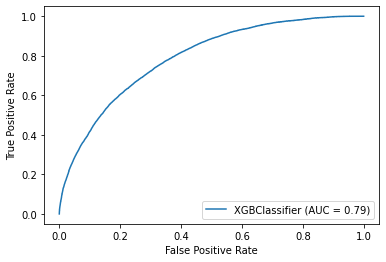

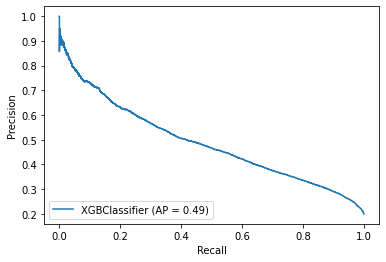

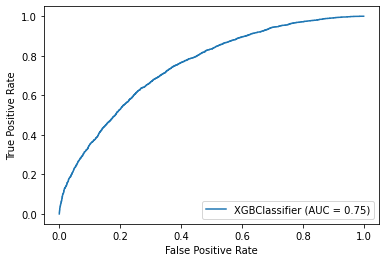

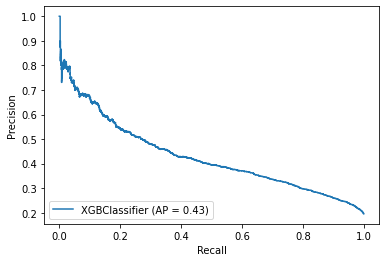

In [14]:
from sklearn.metrics import accuracy_score, f1_score, plot_roc_curve, plot_precision_recall_curve,precision_score, recall_score, matthews_corrcoef


def print_metrics(classifier, X_train, y_train, X_test, y_test):

    print("On training:")

    y_pred_on_train = classifier.predict(X_train)
    print(f"Training f1-score is {f1_score(y_pred_on_train, y_train)}")
    print(f"Training precision is {precision_score(y_pred_on_train, y_train)}")
    print(f"Training recall is {recall_score(y_pred_on_train, y_train)}")
    print(f"Training Matthews correlation coefficient is {matthews_corrcoef(y_pred_on_train, y_train)}")

    plot_roc_curve(classifier, X_train, y_train)
    plot_precision_recall_curve(classifier, X_train, y_train)

    print("On testing:")

    y_pred = classifier.predict(X_test)
    print(f"Testing f1-score is {f1_score(y_pred, y_test)}")
    print(f"Testing average precision is {precision_score(y_pred, y_test)}")
    print(f"Testing average recall is {recall_score(y_pred, y_test)}")
    print(f"Testing Matthews correlation coefficient is {matthews_corrcoef(y_pred, y_test)}")

    plot_roc_curve(classifier, X_test, y_test)
    plot_precision_recall_curve(classifier, X_test, y_test)

print_metrics(classifier, X_train, y_train, X_test, y_test)

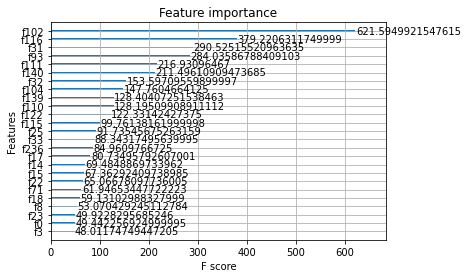

C4_ia: gain 621.5949921547615
C13_rc: gain 379.2206311749999
Q16: gain 290.52515520963635
C3_b: gain 284.03586788409103
C12_oc: gain 216.93096467
Q10_pd: gain 211.49610909473685
Q17: gain 153.59709559899997
C8_ya: gain 147.7604664125
Q10_pc: gain 128.40407251538463
C12_ob: gain 128.19509908911112
Q1_ha: gain 122.33142427375
C13_rb: gain 99.76138161999998
Q7: gain 91.73545675263159
Q18: gain 88.34317495639995
Q34_ed: gain 84.9609766725
S8: gain 80.73495792607001
S5: gain 69.4848869733962
S6: gain 67.36292409738985
Q4: gain 65.06678097736005
Q62: gain 61.94653447722223
S9: gain 59.13102988327999
C18: gain 53.070429245112784
Q5: gain 49.9228295685246
C5: gain 49.442256924999995
C10: gain 48.01174749447205
78 variables have 0 performance gain after one iteration.


In [15]:
n_features_to_print = 25

import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(classifier, max_num_features=n_features_to_print, importance_type="gain")
plt.show()

importances = classifier.get_booster().get_score(importance_type='gain')
importances_sorted = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=True)}
c = 0

to_be_kept_colnames = []
for i, key in enumerate(importances_sorted):
    if i < n_features_to_print:
        print(f"{X.columns[int(key[1:])]}: gain {importances_sorted[key]}")
    to_be_kept_colnames.append(X.columns[int(key[1:])])
    c+=1
print(f"{X.shape[1]-c} variables have 0 performance gain after one iteration.")

# Feature Gains and results

XGBoost has acceptable results. The ROC and AUC show coherent behavior but the Positive Rate curve shows that there is difficulty in reducing the false positives and false negatives. We could try to incorporate these values into the loss function.

The features analysis shows that the S columns have a weak impact on the performance of the model, compared to the C and Q columns. This could perhaps imply that the proposed aids have little impact compared to the actual description of the client and the client's behavioral habits.

# Random Forests

Random Forests is a baggin model whereby each tree is trained on a subset of the training set (random sampling with replacement). Each node then searches for the best feature within a small random subset of features which adds more randomness. Each iteration typically uses $\sqrt N$ features.

## Adjust data for Forest models

Forest models do not deal with Nan values very well.
There are many ways to deal with Nans: 
 - we can use the median value of a single feature and attribute Nans to that value.
 - On large data sets with many features, we can use kNN imputation to deal with Nan values.
 - Lastly, we can remove variables with over 50% missing values.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA


imputer = SimpleImputer(strategy="median")
normalizer = Normalizer()

X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

nan_col_ids = [X.columns.get_loc(col_name) for col_name in X.columns[X.isnull().mean() > 0.5]]

X_train_imp = np.delete(X_train_imp, nan_col_ids, axis=1)
X_test_imp = np.delete(X_test_imp, nan_col_ids, axis=1)

X_train_imp_norm = normalizer.fit_transform(X_train_imp)
X_test_imp_norm = normalizer.transform(X_test_imp)

pca = PCA()
X_train_imp_norm_pca = pca.fit_transform(X_train_imp_norm)
X_test_imp_norm_pca = pca.transform(X_test_imp_norm)

In [ ]:
classifier = RandomForestClassifier(n_estimators=350, max_depth=5, max_features=0.8, class_weight="balanced", verbose=1)

classifier.fit(X_train_imp, y_train)

parameters = {"n_estimators": [200,250,300,350,400,450],
              "max_depth": [4,5,6,7,8,9],
              "max_features": [0.3, 0.5, 0.8]}

rf_scv = RandomizedSearchCV(classifier, param_distributions=parameters, scoring="roc_auc",
                             cv=cv, verbose=3)
#rf_scv.fit(X_train_imp, y_train)

print_metrics(classifier, X_train_imp, y_train, X_test_imp, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


# ExtraTrees

ExtraTrees is similar to Random Forest but differs mainly because there is no bootstrapping and the nodes are split randomly rather than finding the best split.
Since many of the features are actually not very useful, we can increase the proportion of features used for splitting.
PCA reduces performance just like with Random Forest.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier #ExtraTrees

classifier = ExtraTreesClassifier(n_estimators=400, max_depth=5, max_features=0.8, class_weight="balanced", verbose=1)

classifier.fit(X_train_imp,y_train)

parameters = {"n_estimators": [200,250,300,350,400,450],
              "max_depth": [4,5,6,7,8,9],
              "max_features": [0.3, 0.5, 0.8]}

et_scv = RandomizedSearchCV(classifier, param_distributions=parameters, scoring="roc_auc", cv=cv, verbose=3)
#et_scv.fit(X_train_imp, y_train)


print_metrics(classifier, X_train_imp, y_train, X_test_imp, y_test)

# Conclusions

---

XGBoost is a sequential model unlike Random Forest and Extra Trees. This means that each new tree draws characteristics from the last in order to reduce residual errors. All three work well to find the best bias-variance trade off since they combine decision trees which are high variance models. They are also robust against outliers.

XGBoost does tend to overfit so Early Stopping and some hyperparameter tuning is necessary to prevent it from doing so. The other two methods do not overfit as much and present a stagnation in performance after 10 or so trees. We also note that XGBoost uses all the features while the non-boosting methods use maximum $\sqrt N$ features. Random Forest and Extra Trees do not perform as well as XGBoost before overfitting occurs.